In [ ]:
# Setup for Colab/Kaggle
import os
import sys

# --- CONFIGURATION ---
# REPLACE 'USERNAME/REPO_NAME' with your actual GitHub repository path before running remotely!
REPO_URL = "https://github.com/tomal66/AD-SFL.git"
REPO_NAME = "AD-SFL"
# ---------------------

if not os.path.exists("simulation.py"):
    if not os.path.exists(REPO_NAME):
        print(f"Cloning {REPO_URL}...")
        get_ipython().system(f"git clone {REPO_URL}")
        get_ipython().run_line_magic("cd", REPO_NAME)
        print("Installing requirements...")
        get_ipython().system("pip install -r requirements.txt")
    else:
        get_ipython().run_line_magic("cd", REPO_NAME)
        
# Add current directory to path just in case
sys.path.append(os.getcwd())

# SafeSplit Experimentation

This notebook allows you to run experiments with the SafeSplit defense algorithm on MNIST.
You can control the number of clients, poisoning ratio, and other hyperparameters.

In [1]:
import matplotlib.pyplot as plt
from simulation import run_simulation

import os, sys, random
import numpy as np
import torch

print("Python:", sys.version)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

required_files = ["simulation.py", "safesplit.py", "models.py", "data.py"]
missing = [f for f in required_files if not os.path.exists(f)]
if missing:
    raise FileNotFoundError(f"Missing files: {missing}\nPut them in the same directory as this notebook.")
print("All required files found ✅")


Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Torch: 2.8.0+cu126
CUDA available: True
Device: cuda
All required files found ✅


In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Determinism (may reduce speed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("Seed set ✅")


Seed set ✅


## User Configuration

Adjust the parameters below to configure the experiment.

In [3]:
config = {
    "num_clients": 10,         # N in the paper
    "rounds": 50,
    "poison_ratio": 0.2,      # fraction of clients malicious (e.g., 0.2 means 1 out of 5)
    "target_label": 0,        # attack target label
    "dataset": "cifar10",       # just informational; your data.py decides actual dataset
    "distribution": "non_iid", # 'iid' or 'non_iid'
    "alpha": 0.5,

    # Training Hyperparameters:
    "lr": 0.01,
    "momentum": 0.9,
    "batch_size": 32,
    "test_batch_size": 256,

    # Defense controls:
    "defense_enabled": True,
    "low_freq_ratio": 0.25,   # low-frequency extraction ratio for DCT (paper uses low-freq; ratio is configurable)
}

config


{'num_clients': 10,
 'rounds': 50,
 'poison_ratio': 0.2,
 'target_label': 0,
 'dataset': 'cifar10',
 'defense_enabled': True,
 'low_freq_ratio': 0.25}

## Run Experiment

This will run the Split Learning simulation with the specified parameters.

In [4]:
results = run_simulation(config)

Starting Training for 50 rounds on cifar10...
Round 1/50 - Loss: 1.6750 - Val Acc: 27.73% - ASR: 9.83%
Round 2/50 - Loss: 1.3165 - Val Acc: 44.02% - ASR: 11.15%


KeyboardInterrupt: 

## Visualization

Plotting the Main Task Accuracy (MTA) and Backdoor Attack Success Rate (ASR).

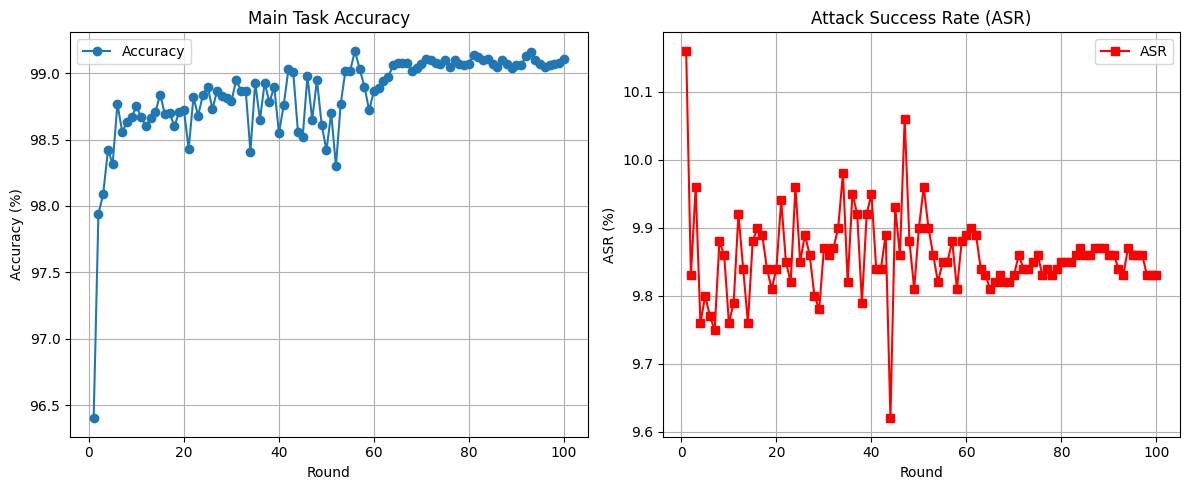

In [ ]:
rounds = range(1, config['rounds'] + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rounds, results['acc'], marker='o', label='Accuracy')
plt.title('Main Task Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, results['asr'], marker='s', color='r', label='ASR')
plt.title('Attack Success Rate (ASR)')
plt.xlabel('Round')
plt.ylabel('ASR (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Comparison: Without Defense (Optional)

Run the same experiment with defense disabled to see the impact of the attack.

Running without defense...
Starting Training for 100 rounds...
Round 1/100 - Loss: 0.3311 - Val Acc: 97.04% - ASR: 9.56%
Round 2/100 - Loss: 0.9994 - Val Acc: 97.56% - ASR: 10.13%
Round 3/100 - Loss: 0.4130 - Val Acc: 97.52% - ASR: 10.37%
Round 4/100 - Loss: 0.2508 - Val Acc: 97.56% - ASR: 10.33%
Round 5/100 - Loss: 0.3117 - Val Acc: 94.89% - ASR: 9.90%
Round 6/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 7/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 8/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 9/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 10/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 11/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 12/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 13/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 14/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 15/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 16/100 - Loss: nan - Val Acc: 9.80% - ASR: 100.00%
Round 17/100 - Loss: 

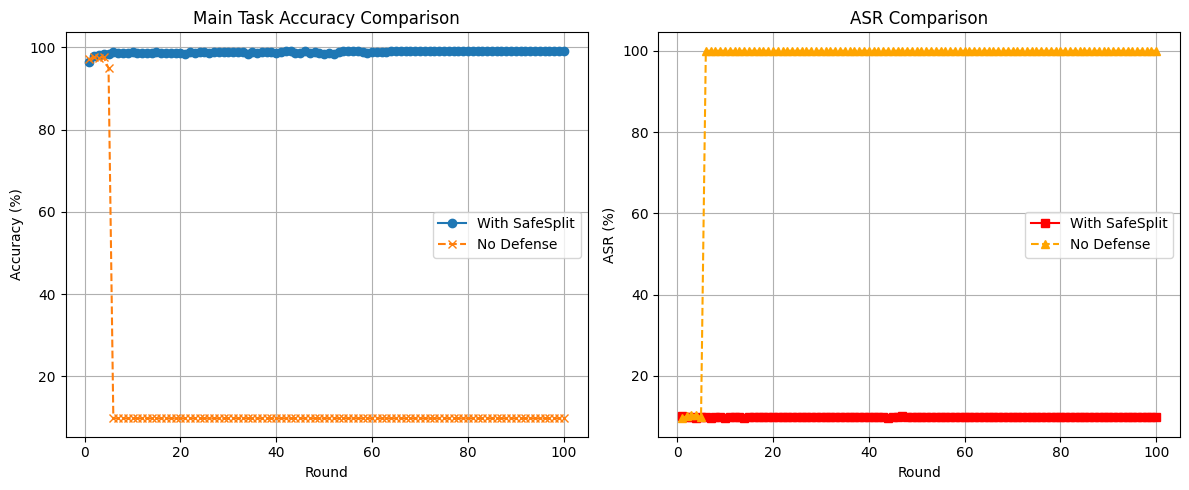

In [ ]:
config_no_defense = config.copy()
config_no_defense['defense_enabled'] = False

print("Running without defense...")
results_no_defense = run_simulation(config_no_defense)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rounds, results['acc'], marker='o', label='With SafeSplit')
plt.plot(rounds, results_no_defense['acc'], marker='x', linestyle='--', label='No Defense')
plt.title('Main Task Accuracy Comparison')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, results['asr'], marker='s', color='r', label='With SafeSplit')
plt.plot(rounds, results_no_defense['asr'], marker='^', color='orange', linestyle='--', label='No Defense')
plt.title('ASR Comparison')
plt.xlabel('Round')
plt.ylabel('ASR (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()